# State Farm Distracted Driver Detection - CNN
This notebook goes trough steps of training a complete CNN model, with initial steps to sanity check and see improvements of the model. For structuring the data input into proper badges, see the VGG16 version of this model and data.
Further it serves as my introduction to the functional API of Keras.

## Initial setup
Initial libraries and functions are loaded and created

We Start by loading the libraries needed to perform the modelling

In [21]:
# Plots displayed inline in notebook
%matplotlib inline

# Make help libraries available
import sys

sys.path.append('D:/anlaursen/libraries')

# Set visible devices, so as to just use a single GPU.
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [22]:
import numpy as np
import pandas as pd
import itertools
import random
import os
import sys
import json
import gc
import bcolz

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from shutil import move
from scipy.ndimage import imread

from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Input, Dense, BatchNormalization, Flatten, Dropout, Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.utils.data_utils import get_file
from keras.regularizers import l2
from keras.metrics import categorical_crossentropy
import keras.backend as K

# Set Theano backend
K.set_image_data_format('channels_last')

Set global variables

In [23]:
# Define home directory variable
current_dir = os.getcwd()
DATA_HOME_DIR = current_dir
path = 'sample/'

# Allow relative imports to directories above main
sys.path.insert(1, os.path.join(sys.path[0], '..'))

## Defining help functions

Various plot and generator functions.

Define plotting function

In [24]:
def plots(ims, figsize = (12, 6), rows = 1, interp = False, titles = None):
    
    if type(ims[0]) is np.ndarray:
        
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0, 2, 3, 1))
            
    f = plt.figure(figsize = figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i + 1)
        sp.axis('Off')
        
        if titles is not None:
            sp.set_title(titles[i], fontsize = 16)
            
        plt.imshow(ims[i], interpolation = None if interp else 'none')

Define confusion matrix function

In [25]:
def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix', cmap = plt.cm.Blues):

    plt.figure()
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment = "center", color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Define a function to normalise the images at the very first step of the model

In [26]:
def get_batches(path, gen = image.ImageDataGenerator(), shuffle = True,
                batch_size = 8, class_mode = 'categorical',
                target_size = (225, 300)):
    
    return gen.flow_from_directory(path, target_size = target_size,
                                   class_mode = class_mode, shuffle = shuffle,
                                   batch_size = batch_size)

## Set up training and validation data

We need to make sure, that the validation dataset contains driver(s) not contained in the training data set! Othervise we will get performance, that cannot be compared to that on Kaggle (the test set contains only unknown drivers.

We start by loading the overview of drivers to a Pandas dataframe

In [ ]:
driver_imgs_list = pd.read_csv('driver_imgs_list.csv')
driver_imgs_list.head()

We randomly select 3 drivers to be used in the validation data set

In [ ]:
# Get array of drivers
drivers = driver_imgs_list['subject'].unique()

# Set seed and pick random driver
r = random.Random(200)
valid_drivers = r.sample(drivers, 3)

valid_drivers_df = driver_imgs_list[(driver_imgs_list['subject'].isin(valid_drivers))] \
                   .reset_index(drop = True)
print(valid_drivers_df.groupby('classname').count())
print(valid_drivers_df.count())

We then create path and extract the images and classnames to be moved.

In [ ]:
valid_drivers_df['path_list'] = valid_drivers_df.apply(lambda row: ['train/' + row['classname'] + \
  '/' + row['img'], 'valid/' + row['classname'] + '/' + row['img']], axis = 1)

valid_drivers_df.head()

# Convert to list
valid_img_path = valid_drivers_df['path_list'].tolist()
print(valid_img_path[0:5])

Create validation, sample and test folders

In [ ]:
%mkdir valid
%mkdir -p sample/train
%mkdir -p sample/valid
%mkdir -p test/unknown
%mkdir models
%mkdir results

Create category subfolders

In [ ]:
%cd $DATA_HOME_DIR/sample/train
!mkdir c{0..9}

%cd $DATA_HOME_DIR/sample/valid
!mkdir c{0..9}

%cd $DATA_HOME_DIR/valid
!mkdir c{0..9}

Move validation data

In [ ]:
# Loop over all validation data
for img in valid_img_path:
    move(img[0], img[1])

Move sample data

In [ ]:
%cd $DATA_HOME_DIR/train/c0
!shuf -n 100 -e * | xargs -i cp {} ~/kaggle/state-farm-distracted-driver-detection/sample/train/c0

%cd $DATA_HOME_DIR/train/c1
!shuf -n 100 -e * | xargs -i cp {} ~/kaggle/state-farm-distracted-driver-detection/sample/train/c1

%cd $DATA_HOME_DIR/train/c2
!shuf -n 100 -e * | xargs -i cp {} ~/kaggle/state-farm-distracted-driver-detection/sample/train/c2

%cd $DATA_HOME_DIR/train/c3
!shuf -n 100 -e * | xargs -i cp {} ~/kaggle/state-farm-distracted-driver-detection/sample/train/c3

%cd $DATA_HOME_DIR/train/c4
!shuf -n 100 -e * | xargs -i cp {} ~/kaggle/state-farm-distracted-driver-detection/sample/train/c4

%cd $DATA_HOME_DIR/train/c5
!shuf -n 100 -e * | xargs -i cp {} ~/kaggle/state-farm-distracted-driver-detection/sample/train/c5

%cd $DATA_HOME_DIR/train/c6
!shuf -n 100 -e * | xargs -i cp {} ~/kaggle/state-farm-distracted-driver-detection/sample/train/c6

%cd $DATA_HOME_DIR/train/c7
!shuf -n 100 -e * | xargs -i cp {} ~/kaggle/state-farm-distracted-driver-detection/sample/train/c7

%cd $DATA_HOME_DIR/train/c8
!shuf -n 100 -e * | xargs -i cp {} ~/kaggle/state-farm-distracted-driver-detection/sample/train/c8

%cd $DATA_HOME_DIR/train/c9
!shuf -n 100 -e * | xargs -i cp {} ~/kaggle/state-farm-distracted-driver-detection/sample/train/c9

%cd $DATA_HOME_DIR/valid/c0
!shuf -n 10 -e * | xargs -i cp {} ~/kaggle/state-farm-distracted-driver-detection/sample/valid/c0

%cd $DATA_HOME_DIR/valid/c1
!shuf -n 10 -e * | xargs -i cp {} ~/kaggle/state-farm-distracted-driver-detection/sample/valid/c1

%cd $DATA_HOME_DIR/valid/c2
!shuf -n 10 -e * | xargs -i cp {} ~/kaggle/state-farm-distracted-driver-detection/sample/valid/c2

%cd $DATA_HOME_DIR/valid/c3
!shuf -n 10 -e * | xargs -i cp {} ~/kaggle/state-farm-distracted-driver-detection/sample/valid/c3

%cd $DATA_HOME_DIR/valid/c4
!shuf -n 10 -e * | xargs -i cp {} ~/kaggle/state-farm-distracted-driver-detection/sample/valid/c4

%cd $DATA_HOME_DIR/valid/c5
!shuf -n 10 -e * | xargs -i cp {} ~/kaggle/state-farm-distracted-driver-detection/sample/valid/c5

%cd $DATA_HOME_DIR/valid/c6
!shuf -n 10 -e * | xargs -i cp {} ~/kaggle/state-farm-distracted-driver-detection/sample/valid/c6

%cd $DATA_HOME_DIR/valid/c7
!shuf -n 10 -e * | xargs -i cp {} ~/kaggle/state-farm-distracted-driver-detection/sample/valid/c7

%cd $DATA_HOME_DIR/valid/c8
!shuf -n 10 -e * | xargs -i cp {} ~/kaggle/state-farm-distracted-driver-detection/sample/valid/c8

%cd $DATA_HOME_DIR/valid/c9
!shuf -n 10 -e * | xargs -i cp {} ~/kaggle/state-farm-distracted-driver-detection/sample/valid/c9

%cd $DATA_HOME_DIR

## Setting up batches
Set up and validate batches

Set up training and validation data.

In [27]:
batch_size = 4

train_batches = get_batches(path + 'train', batch_size = batch_size)
val_batches = get_batches(path + 'valid', batch_size = batch_size, shuffle = False)

Found 1000 images belonging to 10 classes.
Found 100 images belonging to 10 classes.


Check images

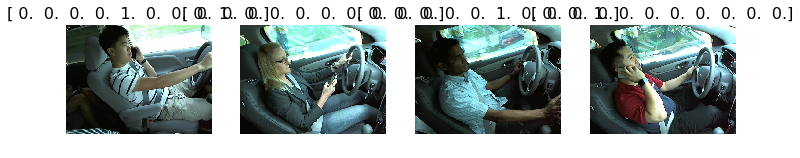

In [28]:
imgs, labels = next(train_batches)

# This shows the 'ground truth'
plots(imgs, titles = labels)

Respecify batch size

In [29]:
batch_size = 32

train_batches = get_batches(path + 'train', batch_size = batch_size)
val_batches = get_batches(path + 'valid', batch_size = batch_size, shuffle = False)

Found 1000 images belonging to 10 classes.
Found 100 images belonging to 10 classes.


## Simple linear model
Testing the performance of a simple linear model, so as to have a base line to compare to.

We define a simple linear function. We add batch normalisation to the first layer to avoid having to do it manually.

In [30]:
# Input tensor
inputs = Input(shape = (225, 300, 3))

# Create simple linear network. Start with batchnormalisation layer,
# such that we do not need this 
x = BatchNormalization()(inputs)
x = Flatten()(x)
predictions = Dense(10, activation = 'softmax')(x)

# Create model
model = Model(inputs = inputs, outputs = predictions)
model.compile(optimizer = Adam(lr = 0.001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

Train the model

In [31]:
model.fit_generator(train_batches,
                    steps_per_epoch = np.int(train_batches.samples / train_batches.batch_size),
                    epochs = 2,
                    validation_data = val_batches,
                    validation_steps = np.int(val_batches.samples / val_batches.batch_size))

Epoch 1/2
31/31 [==============================] - 9s - loss: 13.3420 - acc: 0.1341 - val_loss: 14.4391 - val_acc: 0.1042
Epoch 2/2
31/31 [==============================] - 7s - loss: 14.4214 - acc: 0.1028 - val_loss: 14.2218 - val_acc: 0.1176


Seems like we are stabilising close to random guessing. We can check the model specification to check that we have the desired number of parameters.

In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 225, 300, 3)       0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 225, 300, 3)       12        
_________________________________________________________________
flatten_5 (Flatten)          (None, 202500)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                2025010   
Total params: 2,025,022
Trainable params: 2,025,016
Non-trainable params: 6
_________________________________________________________________


We have a desired high number of parameters. As we are stabilising on random guessing, we might just be assigning two different classes to the data set. That is our learning rate might be too high.

In [ ]:
val_preds = model.predict_generator(val_batches, val_batches.samples / val_batches.batch_size)
val_preds.sum(axis = 0)

We are actually just assigning two single values for each itteration. That is no good. Let's rerun with a lower learning rate.

In [ ]:
inputs = Input(shape = (225, 300, 3))

x = BatchNormalization()(inputs)
x = Flatten()(x)
predictions = Dense(10, activation = 'softmax')(x)

model = Model(inputs = inputs, outputs = predictions)
model.compile(optimizer = Adam(lr = 1e-5),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

model.fit_generator(train_batches,
                    steps_per_epoch = np.int(train_batches.samples / train_batches.batch_size),
                    epochs = 2,
                    validation_data = val_batches,
                    validation_steps = np.int(val_batches.samples / val_batches.batch_size))

That certainly did the trick. We then increase the learning rate and see, where that gets us.

In [ ]:
# Increase the learning rate
model.optimizer.lr = 0.001

model.fit_generator(train_batches,
                    steps_per_epoch = np.int(train_batches.samples / train_batches.batch_size),
                    epochs = 4,
                    validation_data = val_batches,
                    validation_steps = np.int(val_batches.samples / val_batches.batch_size))

So we are able to model the training set quite well. But, we are overfitting a lot.  Lets consider the confusion matrix. 

In [ ]:
def test(model, path, batch_size = 5):
    
    test_batches = get_batches(path, shuffle = False, batch_size = batch_size, class_mode = None)
    
    return test_batches, model.predict_generator(test_batches, np.int(test_batches.samples / test_batches.batch_size))

In [ ]:
val_batch_test, val_predictions_test = test(model, path + 'valid')

In [ ]:
cm = confusion_matrix(val_batch_test.classes, np.argmax(val_predictions_test, axis = 1))
plot_confusion_matrix(cm, val_batch_test.class_indices)

This model, tough having high fit on the training set perform rather bad on the validation data. So let's improve it.

## L2 regularisation

Our model is overfitting a lot, so let's add l2 regularisation and see if it improves things.

In [ ]:
inputs = Input(shape = (225, 300, 3))

x = BatchNormalization()(inputs)
x = Flatten()(x)
predictions = Dense(10, activation = 'softmax', kernel_regularizer = l2(0.01))(x)

model = Model(inputs = inputs, outputs = predictions)
model.compile(optimizer = Adam(lr = 1e-5),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

model.fit_generator(train_batches,
                    steps_per_epoch = np.int(train_batches.samples / train_batches.batch_size),
                    epochs = 2,
                    validation_data = val_batches,
                    validation_steps = np.int(val_batches.samples / val_batches.batch_size))

Train for a few more epochs with higher learning rate

In [ ]:
# Increase the learning rate
model.optimizer.lr = 0.001

model.fit_generator(train_batches,
                    steps_per_epoch = np.int(train_batches.samples / train_batches.batch_size),
                    epochs = 4,
                    validation_data = val_batches,
                    validation_steps = np.int(val_batches.samples / val_batches.batch_size))

Slight improvement there, but still not a satisfying result.

## Adding a hidden layer

Make a deeper network by adding a single hidden layer

In [ ]:
inputs = Input(shape = (225, 300, 3))

x = BatchNormalization()(inputs)
x = Flatten()(x)
x = Dense(500, activation = 'relu')(x)
predictions = Dense(10, activation = 'softmax', kernel_regularizer = l2(0.01))(x)

model = Model(inputs = inputs, outputs = predictions)
model.compile(optimizer = Adam(lr = 1e-5),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

model.fit_generator(train_batches,
                    steps_per_epoch = np.int(train_batches.samples / train_batches.batch_size),
                    epochs = 2,
                    validation_data = val_batches,
                    validation_steps = np.int(val_batches.samples / val_batches.batch_size))

Retrain again with a higher learning rate

In [ ]:
# Increase the learning rate
model.optimizer.lr = 0.01

model.fit_generator(train_batches,
                    steps_per_epoch = np.int(train_batches.samples / train_batches.batch_size),
                    epochs = 4,
                    validation_data = val_batches,
                    validation_steps = np.int(val_batches.samples / val_batches.batch_size))

Not much help there. We already have a lot of parameters, so a hidden layer is not going to do much for image recognintion. A convolutional layer might be more efficient.

## A convolutional layer

Make a model with a single convolutional layer.

In [ ]:
inputs = Input(shape = (225, 300, 3))

norm_layer = BatchNormalization()(inputs)
conv_layer_1 = ZeroPadding2D((1, 1))(norm_layer)
conv_layer_1 = Conv2D(32, kernel_size = (3, 3), strides = (1, 1), activation = 'relu')(conv_layer_1)
conv_layer_1 = BatchNormalization(axis = 1)(conv_layer_1)
conv_layer_1 = MaxPooling2D((3, 3))(conv_layer_1)
conv_layer_2 = ZeroPadding2D((1, 1))(conv_layer_1)
conv_layer_2 = Conv2D(64, kernel_size = (3, 3), strides = (1, 1), activation = 'relu')(conv_layer_2)
conv_layer_2 = BatchNormalization(axis = 1)(conv_layer_2)
conv_layer_2 = MaxPooling2D((3, 3))(conv_layer_2)
flat_layer = Flatten()(conv_layer_2)
dense_layer_1 = Dense(200, activation = 'relu')(flat_layer)
dense_layer_1 = BatchNormalization()(dense_layer_1)
predictions = Dense(10, activation = 'softmax')(dense_layer_1)

model = Model(inputs = inputs, outputs = predictions)
model.compile(optimizer = Adam(lr = 1e-4),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

model.fit_generator(train_batches,
                    steps_per_epoch = np.int(train_batches.samples / train_batches.batch_size),
                    epochs = 2,
                    validation_data = val_batches,
                    validation_steps = np.int(val_batches.samples / val_batches.batch_size))

In [ ]:
# Increase the learning rate
model.optimizer.lr = 0.001

model.fit_generator(train_batches,
                    steps_per_epoch = np.int(train_batches.samples / train_batches.batch_size),
                    epochs = 4,
                    validation_data = val_batches,
                    validation_steps = np.int(val_batches.samples / val_batches.batch_size))

In [ ]:
model.summary()

Clearly the model converges to 1 with accuracy. Thus we need to do something about the overfitting.

## Augmenting the data

To allieve the overfitting, we can augment the data. One should consider various combinations of the generator parameters, holding other parameters equal. Here we just specify the final generator.

We the define the final generator, and consider it.

In [ ]:
gen = image.ImageDataGenerator(rotation_range = 15,
                               width_shift_range = 0.1,
                               height_shift_range = 0.05,
                               shear_range = 0.1,
                               channel_shift_range = 20)

We then consider an example to sanity check the generator.

In [ ]:
# Create a 'batch' of a single image
img = np.expand_dims(imread('train/c0/img_99971.jpg'), 0)

# Request the generator to create batches from this image
aug_iter = gen.flow(img)

We then get eight examples of the augmented images.

In [ ]:
# Get eight examples of these augmented images
aug_imgs = [next(aug_iter)[0].astype(np.uint8) for i in range(8)]

The original image:

In [ ]:
plt.imshow(img[0])

And our augmented images

In [ ]:
plots(aug_imgs, (20, 7), 2)

## CNN with augmented data
We retrain the model with augmented data. Start by setting the data.

In [ ]:
batch_size = 32

train_batches = get_batches(path + 'train', gen = gen, batch_size = batch_size)
val_batches = get_batches(path + 'valid', batch_size = batch_size, shuffle = False)

Then re-run the model with the aumented batches.

In [33]:
inputs = Input(shape = (225, 300, 3))

norm_layer = BatchNormalization()(inputs)
conv_layer_1 = ZeroPadding2D((1, 1))(norm_layer)
conv_layer_1 = Conv2D(32, kernel_size = (3, 3), strides = (1, 1), activation = 'relu')(conv_layer_1)
conv_layer_1 = BatchNormalization()(conv_layer_1)
conv_layer_1 = MaxPooling2D((3, 3))(conv_layer_1)
conv_layer_2 = ZeroPadding2D((1, 1))(conv_layer_1)
conv_layer_2 = Conv2D(64, kernel_size = (3, 3), strides = (1, 1), activation = 'relu')(conv_layer_2)
conv_layer_2 = BatchNormalization()(conv_layer_2)
conv_layer_2 = MaxPooling2D((3, 3))(conv_layer_2)
flat_layer = Flatten()(conv_layer_2)
dense_layer_1 = Dense(200, activation = 'relu')(flat_layer)
dense_layer_1 = BatchNormalization()(dense_layer_1)
predictions = Dense(10, activation = 'softmax')(dense_layer_1)

model = Model(inputs = inputs, outputs = predictions)
model.compile(optimizer = Adam(lr = 1e-4),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

model.fit_generator(train_batches,
                    steps_per_epoch = np.int(train_batches.samples / train_batches.batch_size),
                    epochs = 2,
                    validation_data = val_batches,
                    validation_steps = np.int(val_batches.samples / val_batches.batch_size))

Epoch 1/2
31/31 [==============================] - 9s - loss: 1.7776 - acc: 0.4618 - val_loss: 1.9145 - val_acc: 0.3676
Epoch 2/2
31/31 [==============================] - 7s - loss: 0.4732 - acc: 0.9013 - val_loss: 2.2908 - val_acc: 0.2353


The training accuracy gets better, but the validation accuracy gets worse. Not good. However, this might be due to the low learning rate, so we try to adjust it and continue training for more epochs.

In [34]:
# Increase the learning rate
model.optimizer.lr = 0.0001

model.fit_generator(train_batches,
                    steps_per_epoch = np.int(train_batches.samples / train_batches.batch_size),
                    epochs = 4,
                    validation_data = val_batches,
                    validation_steps = np.int(val_batches.samples / val_batches.batch_size))

Epoch 1/4
31/31 [==============================] - 8s - loss: 0.1574 - acc: 0.9828 - val_loss: 2.6331 - val_acc: 0.1471
Epoch 2/4
31/31 [==============================] - 7s - loss: 0.0574 - acc: 0.9980 - val_loss: 2.8549 - val_acc: 0.0147
Epoch 3/4
31/31 [==============================] - 7s - loss: 0.0305 - acc: 1.0000 - val_loss: 2.9976 - val_acc: 0.0000e+00
Epoch 4/4
31/31 [==============================] - 7s - loss: 0.0190 - acc: 1.0000 - val_loss: 3.0298 - val_acc: 0.0147


Much better. Then it's just time to increase the number of epochs and see where it gets us.

In [ ]:
model.fit_generator(train_batches,
                    steps_per_epoch = np.int(train_batches.samples / train_batches.batch_size),
                    epochs = 24,
                    validation_data = val_batches,
                    validation_steps = np.int(val_batches.samples / val_batches.batch_size))

Lets run even more and see if we can get the valuation accuracy over 0.6

In [ ]:
model.fit_generator(train_batches,
                    steps_per_epoch = np.int(train_batches.samples / train_batches.batch_size),
                    epochs = 24,
                    validation_data = val_batches,
                    validation_steps = np.int(val_batches.samples / val_batches.batch_size))

Seems like we can't improve much more using the sample data set. The next step is to add dropout, where we have to use the entire dataset anyway. Let's submit to Kaggle and get a baseline performance indications

## Submitting to Kaggle

In [ ]:
# Define clipping in case we have to correct predictions when eval measure is skewed
def do_clip(arr, mx):
    return np.clip(arr, (1 - mx) / 9, mx)

In [ ]:
test_batches = get_batches('test', shuffle = False, batch_size = 2, class_mode = None)

test_pred = model.predict_generator(test_batches, np.int(test_batches.samples / test_batches.batch_size))

In [ ]:
classes = sorted(val_batches.class_indices, key = val_batches.class_indices.get)

In [ ]:
submission = pd.DataFrame(test_pred, columns = classes)
submission.insert(0, 'img', [a[8:] for a in test_batches.filenames])
submission.head()

In [ ]:
submission_file_name = 'results/CNN-augmented-data-small-sample.gz'
submission.to_csv(submission_file_name, index = False, compression = 'gzip')

Next we turn towards adding dropout and training on the entire dataset.

## CNN with batch norm and dropout
To further restrict overfitting we add dropout, which means we have to train on the entire dataset, which is quite time consuming. As sucj we reduce the target size, to reduce the number of parameters in order to improve the execution time.

Set up new batches

In [ ]:
path = ''

batch_size = 32

gen = image.ImageDataGenerator(rotation_range = 15,
                               width_shift_range = 0.1,
                               height_shift_range = 0.05,
                               shear_range = 0.1,
                               channel_shift_range = 20)

train_batches = get_batches(path + 'train', gen = gen, batch_size = batch_size, target_size = (225, 300))
val_batches = get_batches(path + 'valid', batch_size = batch_size, target_size = (225, 300), shuffle = False)

We add dropout and make the model a tiny bit deeper.

In [ ]:
inputs = Input(shape = (225, 300, 3))

norm_layer = BatchNormalization(axis = 1)(inputs)

# Conv. layer 1
conv_layer_1 = ZeroPadding2D((1, 1))(norm_layer)
conv_layer_1 = Dropout(0.1)(conv_layer_1)
conv_layer_1 = Conv2D(32, kernel_size = (3, 3), strides = (1, 1), activation = 'relu')(conv_layer_1)
conv_layer_1 = BatchNormalization()(conv_layer_1)
conv_layer_1 = MaxPooling2D((3, 3))(conv_layer_1)

# Conv. layer 2
conv_layer_2 = ZeroPadding2D((1, 1))(conv_layer_1)
conv_layer_2 = Dropout(0.2)(conv_layer_2)
conv_layer_2 = Conv2D(64, kernel_size = (3, 3), strides = (1, 1), activation = 'relu')(conv_layer_2)
conv_layer_2 = BatchNormalization()(conv_layer_2)
conv_layer_2 = MaxPooling2D((3, 3))(conv_layer_2)

# Conv. layer 3
conv_layer_3 = ZeroPadding2D((1, 1))(conv_layer_2)
conv_layer_3 = Dropout(0.3)(conv_layer_3)
conv_layer_3 = Conv2D(128, kernel_size = (3, 3), strides = (1, 1), activation = 'relu')(conv_layer_3)
conv_layer_3 = BatchNormalization()(conv_layer_3)
conv_layer_3 = MaxPooling2D((3, 3))(conv_layer_3)

# Flat layer
flat_layer = Flatten()(conv_layer_3)

# Dense layer 1
dense_layer_1 = Dropout(0.5)(flat_layer)
dense_layer_1 = Dense(200, activation = 'relu')(dense_layer_1)


# Dense layer 2
dense_layer_2 = BatchNormalization()(dense_layer_1)
dense_layer_2 = Dropout(0.5)(dense_layer_2)
dense_layer_2 = Dense(200, activation = 'relu')(dense_layer_2)

# Dense layer 3
dense_layer_3 = BatchNormalization()(dense_layer_2)
dense_layer_3 = Dropout(0.5)(dense_layer_3)
predictions = Dense(10, activation = 'softmax')(dense_layer_3)

model = Model(inputs = inputs, outputs = predictions)
model.compile(optimizer = Adam(lr = 1e-5),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

model.fit_generator(train_batches,
                    steps_per_epoch = np.int(train_batches.samples / train_batches.batch_size),
                    epochs = 2,
                    validation_data = val_batches,
                    validation_steps = np.int(val_batches.samples / val_batches.batch_size))

Our training is progressing extremely slowly. It might indicate that we have a bit much dropout. Given the data, dropout in the last dense layers might be enough. As such we remove the conv dropout and try and rerun.

In [ ]:
inputs = Input(shape = (225, 300, 3))

norm_layer = BatchNormalization()(inputs)

# Conv. layer 1
conv_layer_1 = ZeroPadding2D((1, 1))(norm_layer)
conv_layer_1 = Conv2D(32, kernel_size = (3, 3), strides = (1, 1), activation = 'relu')(conv_layer_1)
conv_layer_1 = BatchNormalization()(conv_layer_1)
conv_layer_1 = MaxPooling2D((3, 3))(conv_layer_1)

# Conv. layer 2
conv_layer_2 = ZeroPadding2D((1, 1))(conv_layer_1)
conv_layer_2 = Conv2D(64, kernel_size = (3, 3), strides = (1, 1), activation = 'relu')(conv_layer_2)
conv_layer_2 = BatchNormalization()(conv_layer_2)
conv_layer_2 = MaxPooling2D((3, 3))(conv_layer_2)

# Conv. layer 3
conv_layer_3 = ZeroPadding2D((1, 1))(conv_layer_2)
conv_layer_3 = Conv2D(128, kernel_size = (3, 3), strides = (1, 1), activation = 'relu')(conv_layer_3)
conv_layer_3 = BatchNormalization()(conv_layer_3)
conv_layer_3 = MaxPooling2D((3, 3))(conv_layer_3)

# Flat layer
flat_layer = Flatten()(conv_layer_3)

# Dense layer 1
dense_layer_1 = Dense(200, activation = 'relu')(flat_layer)

# Dense layer 2
dense_layer_2 = BatchNormalization()(dense_layer_1)
dense_layer_2 = Dropout(0.5)(dense_layer_2)
dense_layer_2 = Dense(200, activation = 'relu')(dense_layer_2)

# Dense layer 3
dense_layer_3 = BatchNormalization()(dense_layer_2)
dense_layer_3 = Dropout(0.5)(dense_layer_3)
predictions = Dense(10, activation = 'softmax')(dense_layer_3)

model = Model(inputs = inputs, outputs = predictions)
model.compile(optimizer = Adam(lr = 1e-4),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

model.fit_generator(train_batches,
                    steps_per_epoch = np.int(train_batches.samples / train_batches.batch_size),
                    epochs = 2,
                    validation_data = val_batches,
                    validation_steps = np.int(val_batches.samples / val_batches.batch_size))

Looks more promising. We even seem to be overfitting a bit now. Let's run a bit more.

In [ ]:
model.optimizer.lr = 1e-4

model.fit_generator(train_batches,
                    steps_per_epoch = np.int(train_batches.samples / train_batches.batch_size),
                    epochs = 2,
                    validation_data = val_batches,
                    validation_steps = np.int(val_batches.samples / val_batches.batch_size))

Now we're heading in the right direction. And the overfitting is even gone. Let's run at an even lower learning rate some more epochs and see how far we can get.

In [ ]:
model.optimizer.lr = 1e-5

model.fit_generator(train_batches,
                    steps_per_epoch = np.int(train_batches.samples / train_batches.batch_size),
                    epochs = 6,
                    validation_data = val_batches,
                    validation_steps = np.int(val_batches.samples / val_batches.batch_size))

Now we start to overfit, and it seems that the valuaration accuracy levels out.So in the area of 0.76-0.78 is the best we can do. We

In [ ]:
model.save_weights('models/cnn-dense-dropout.h5')

So now we are starting to overfit. The accuracy increases, and the validation accuracy remains fairly constant.
We might have had better succes, if we had sticked to the model with more dropout, but due to the slow increase in accuracy, training would have taken considerable long time.
The result would propably be the same at any rate. This is due to the rather low number of training images in this problem (especially considering the number of test images). We are only training on a small number of drivers.

This warrents a return to a VGG style model, which we first considered. Let's see if we can't improve on that model further by updating at least the dense layer to more modern standards.

Before doing that, we submit our current model to Kaggle, to get a better idea of how we are doing.

### Submitting to Kaggle

In [ ]:
test_batches = get_batches('test', shuffle = False, batch_size = 2, target_size = (224, 224), class_mode = None)

test_pred = model.predict_generator(test_batches, np.int(test_batches.samples / test_batches.batch_size))

In [ ]:
classes = sorted(val_batches.class_indices, key = val_batches.class_indices.get)

To get the best result on Kaggle, we do some clipping.

In [ ]:
def do_clip(arr, mx): return np.clip(arr, (1 - mx) / 9, mx)

In [ ]:
valid_batches = get_batches('valid', shuffle = False, batch_size = 50, target_size = (224, 224), class_mode = None)

valid_pred = model.predict_generator(valid_batches, np.int(valid_batches.samples / valid_batches.batch_size))

Time to test the best level op clipping.

In [ ]:
test_clip = []
for i in np.arange(0.70, 1.0, 0.01):
    test_clip.append([i, categorical_crossentropy(to_categorical(valid_batches.classes), do_clip(valid_pred, i)).eval().mean()])

min(test_clip, key = lambda x: x[1])

In [ ]:
sumbit_pred = do_clip(test_pred, 0.89)

And make the submission

In [ ]:
submission = pd.DataFrame(sumbit_pred, columns = classes)
submission.insert(0, 'img', [a[8:] for a in test_batches.filenames])
submission.head()

In [ ]:
submission_file_name = 'results/CNN-augmented-batch-norm-full-data.gz'
submission.to_csv(submission_file_name, index = False, compression = 'gzip')

This lands us on a solid 0.93 for a 516 position on the leaderboard.

## Improved VGG style network
We return to the VGG style network (see other notebook), but try to improve it.

We start by defining the vgg16 model again. First the layers and preprocessing.

In [ ]:
def ConvBlock(layers, model_in, filters, name):
    
    model_out = model_in
    for i in range(layers): 
        model_out = ZeroPadding2D((1, 1))(model_out)
        model_out = Conv2D(filters,
                           kernel_size = (3, 3),
                           strides = (1, 1),
                           activation = 'relu',
                           name = name + '_' + str(i))(model_out)
    
    model_out = MaxPooling2D((2, 2), strides = (2, 2))(model_out)
    
    return model_out
    
def FCBlock(model_in, name):
    
    model_out = Dense(4096, activation = 'relu', name = name)(model_in)
    model_out = Dropout(0.5)(model_out)
    
    return model_out
    
# Mean of each channel as provided by VGG researchers (i.e. hard coded)
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((1, 1, 3))

def vgg_preprocess(x):
    
    x = x - vgg_mean # subtract mean
    return x[:, ::-1] # reverse axis bgr->rgb

Next the actual vgg16 model

In [ ]:
def VGG_16():
    
    # Define input
    inputs = Input(shape = (224, 224, 3))
    
    # Normalise first layer
    norm_layer = Lambda(vgg_preprocess,
                        output_shape = (224, 224, 3))(inputs)

    # Define convolutional layers
    conv_layer_1 = ConvBlock(2, norm_layer, 64, name = 'conv_layer_1')
    conv_layer_2 = ConvBlock(2, conv_layer_1, 128, name = 'conv_layer_2')
    conv_layer_3 = ConvBlock(3, conv_layer_2, 256, name = 'conv_layer_3')
    conv_layer_4 = ConvBlock(3, conv_layer_3, 512, name = 'conv_layer_4')
    conv_layer_5 = ConvBlock(3, conv_layer_4, 512, name = 'conv_layer_5')

    # Flatten
    flat_layer = Flatten()(conv_layer_5)
    
    # Fully connected layers
    fc_layer_1 = FCBlock(flat_layer, name = 'fc_layer_1')
    fc_layer_2 = FCBlock(fc_layer_1, name = 'fc_layer_2')
    
    # Prediction layer
    predictions = Dense(1000, activation = 'softmax', name = 'prediction')(fc_layer_2)
    
    # Define model
    model = Model(inputs = inputs, outputs = predictions)
    
    return model

Then we run the model.

In [ ]:
model = VGG_16()

model.summary()

And assign the weights

In [ ]:
# Assign the weights
model.load_weights('weights/vgg16.h5')

Then we define the convolutional layer.

In [ ]:
# Define convolutional layers
last_conv_idx = [i for i, l in enumerate(model.layers) if type(l) is Conv2D][-1]
conv_layers = model.layers[:last_conv_idx + 1]

We then define a model using only the convolutional layers.

In [ ]:
conv_model = Sequential(conv_layers)
conv_model.summary()

We then precompute the convolutional layers in order to save time. We set shuffle to false, such that we get all images pre computed and we don't get the same images several times.

In [ ]:
def save_array(fname, arr):
    c = bcolz.carray(arr, rootdir = fname, mode = 'w')
    c.flush()
      
def load_array(fname):
    return bcolz.open(fname)[:]

In [ ]:
path = ''

train_batches = get_batches(path + 'train', batch_size = 44, target_size = (224, 224), shuffle = False)

valid_batches = get_batches(path + 'valid', batch_size = 50, target_size = (224, 224), shuffle = False)

test_batches = get_batches(path + 'test', batch_size = 2, target_size = (224, 224), shuffle = False, class_mode = None)

In [ ]:
conv_feat = conv_model.predict_generator(train_batches, np.int(train_batches.samples / train_batches.batch_size))
save_array(path + 'results/conv_computed/conv_feat.dat', conv_feat)

del conv_feat
gc.collect()

In [ ]:
conv_val_feat = conv_model.predict_generator(valid_batches, np.int(valid_batches.samples / valid_batches.batch_size))
save_array(path + 'results/conv_computed/conv_val_feat.dat', conv_val_feat)

del conv_val_feat
gc.collect()

We then save the computed layers.

In [ ]:
conv_test_feat = conv_model.predict_generator(test_batches, np.int(test_batches.samples / test_batches.batch_size))
save_array(path + 'results/conv_computed/conv_test_feat.dat', conv_test_feat)

del conv_test_feat
gc.collect()

Load the layers

In [ ]:
conv_feat = load_array(path + 'results/conv_computed/conv_feat.dat')
conv_val_feat = load_array(path + 'results/conv_computed/conv_val_feat.dat')

## VGG model with batchnorm dense laysers on pretrained conv layers

Since we've pre-computed the output of the last convolutional layer, we need to create a network that takes that as input, and predicts our 10 classes. Let's try using a simplified version of VGG's dense layers.

In [ ]:
def batch_norm_model(base_model, p):
    
    inputs = Input(shape = base_model[-1].output_shape[1:])
    pooling = MaxPooling2D((2, 2), strides = (2, 2))(inputs)
        
    flat_layer = Flatten()(pooling)
        
    dense_layer_1 = Dropout(p / 2)(flat_layer)
    dense_layer_1 = Dense(128, activation='relu')(dense_layer_1)
    dense_layer_2 = BatchNormalization()(dense_layer_1)
    dense_layer_2 = Dropout(p / 2)(dense_layer_2)
    dense_layer_2 = Dense(128, activation='relu')(dense_layer_2)
    dense_layer_3 = BatchNormalization()(dense_layer_2)
    dense_layer_3 = Dropout(p)(dense_layer_3)
    dense_layer_3 = Dense(10, activation='softmax')(dense_layer_3)
    
    model = Model(inputs = inputs, outputs = dense_layer_3)
    
    return model

p = 0.8

batch_size = 32

Lets define and compile the model.

In [ ]:
bn_model = batch_norm_model(conv_layers, p)

bn_model.compile(optimizer = Adam(lr = 0.001),
                 loss = 'categorical_crossentropy',
                 metrics = ['accuracy'])

bn_model.fit(x = conv_feat,
             y = to_categorical(train_batches.classes),
             batch_size = batch_size,
             epochs = 1,
             validation_data = (conv_val_feat, to_categorical(valid_batches.classes)))

Great result! Time to increase the learning rate

In [ ]:
bn_model.optimizer.lr = 0.01

bn_model.fit(x = conv_feat,
             y = to_categorical(train_batches.classes),
             batch_size = batch_size,
             epochs = 2,
             validation_data = (conv_val_feat, to_categorical(valid_batches.classes)))

Great result around the 0.8 accuracy mark. We'll see if we can improve it by adding 5 epochs worth of augmented data (that we precompute).

## VGG model with precomputed augmentation and dropout.

We precompute some augmented data in order to improve our model.

In [ ]:
gen_t = image.ImageDataGenerator(rotation_range = 15,
                                 height_shift_range = 0.05,
                                 shear_range = 0.1,
                                 channel_shift_range = 20,
                                 width_shift_range = 0.1)

da_batches = get_batches(path + 'train', gen_t,
                         batch_size = 44,
                         shuffle = False,
                         target_size = (224, 224))

We use those to create a dataset of convolutional features 5x bigger than the training set.

In [ ]:
da_conv_feat = conv_model.predict_generator(da_batches, np.int(da_batches.samples / da_batches.batch_size) * 3)
save_array(path + 'results/conv_computed/da_conv_feat.dat', da_conv_feat)

del da_conv_feat
gc.collect()

We then load the augmented data

In [ ]:
da_conv_feat = load_array(path + 'results/conv_computed/da_conv_feat.dat')

We combine the augmented data with the real data

In [ ]:
da_conv_feat = np.concatenate([da_conv_feat, conv_feat])

We can then run the model again, but we try to use some bigger dense layers and some more dropout.

In [ ]:
def batch_norm_model_bigger(base_model, p):
    
    inputs = Input(shape = base_model[-1].output_shape[1:])
    pooling = MaxPooling2D((2, 2), strides = (2, 2))(inputs)
        
    flat_layer = Flatten()(pooling)
        
    dense_layer_1 = Dropout(p)(flat_layer)
    dense_layer_1 = Dense(256, activation='relu')(dense_layer_1)
    dense_layer_2 = BatchNormalization()(dense_layer_1)
    dense_layer_2 = Dropout(p)(dense_layer_2)
    dense_layer_2 = Dense(256, activation='relu')(dense_layer_2)
    dense_layer_3 = BatchNormalization()(dense_layer_2)
    dense_layer_3 = Dropout(p)(dense_layer_3)
    dense_layer_3 = Dense(10, activation='softmax')(dense_layer_3)
    
    model = Model(inputs = inputs, outputs = dense_layer_3)
    
    return model

p = 0.8

batch_size = 32

We define and combine the model

In [ ]:
bn_model_bigger = batch_norm_model_bigger(conv_layers, p)

bn_model_bigger.compile(optimizer = Adam(lr = 0.001),
                        loss = 'categorical_crossentropy',
                        metrics = ['accuracy'])

bn_model_bigger.fit(x = da_conv_feat,
                    # Note we have increased the data 6 fold
                    y = np.concatenate([to_categorical(train_batches.classes)] * 4),
                    batch_size = batch_size,
                    epochs = 1,
                    validation_data = (conv_val_feat, to_categorical(valid_batches.classes)))

We increase the learning rate and run some more epochs.

In [ ]:
bn_model_bigger.optimizer.lr = 0.01

bn_model_bigger.fit(x = da_conv_feat,
                    # Note we have increased the data 6 fold
                    y = np.concatenate([to_categorical(train_batches.classes)] * 4),
                    batch_size = batch_size,
                    epochs = 4,
                    validation_data = (conv_val_feat, to_categorical(valid_batches.classes)))

And lower the learning rate again and run some more.

In [ ]:
bn_model_bigger.optimizer.lr = 0.0001

bn_model_bigger.fit(x = da_conv_feat,
                    # Note we have increased the data 6 fold
                    y = np.concatenate([to_categorical(train_batches.classes)] * 4),
                    batch_size = batch_size,
                    epochs = 4,
                    validation_data = (conv_val_feat, to_categorical(valid_batches.classes)))

Great starting point. We save the weights here.

In [ ]:
bn_model.save_weights(path + 'models/vgg_model_augmented.h5')

## Pseudolabeling

We're going to try using a combination of [pseudo labeling](http://deeplearning.net/wp-content/uploads/2013/03/pseudo_label_final.pdf) and [knowledge distillation](https://arxiv.org/abs/1503.02531) to allow us to use unlabeled data (i.e. do semi-supervised learning). For our initial experiment we'll use the validation set as the unlabeled data, so that we can see that it is working without using the test set. At a later date we'll try using the test set.

In [ ]:
val_pseudo = bn_model_bigger.predict(conv_val_feat, batch_size = 50)

We concatenate thse pseudo labels with our training labels

In [ ]:
comb_pseudo = np.concatenate([np.concatenate([to_categorical(train_batches.classes)] * 4), val_pseudo])
comb_feat = np.concatenate([da_conv_feat, conv_val_feat])

In [ ]:
print(comb_feat.shape)
print(comb_pseudo.shape)

And fine tune our model using the data

In [ ]:
bn_model_bigger.fit(x = comb_feat,
                    # Note we have increased the data 6 fold
                    y = comb_pseudo,
                    batch_size = batch_size,
                    epochs = 1,
                    validation_data = (conv_val_feat, to_categorical(valid_batches.classes)))

In [ ]:
bn_model_bigger.fit(x = comb_feat,
                    # Note we have increased the data 6 fold
                    y = comb_pseudo,
                    batch_size = batch_size,
                    epochs = 4,
                    validation_data = (conv_val_feat, to_categorical(valid_batches.classes)))

Lets try with a very low learning rate

In [ ]:
bn_model_bigger.optimizer.lr = 0.00001

bn_model_bigger.fit(x = comb_feat,
                    # Note we have increased the data 6 fold
                    y = comb_pseudo,
                    batch_size = batch_size,
                    epochs = 4,
                    validation_data = (conv_val_feat, to_categorical(valid_batches.classes)))

That was a great improvement. Lets expand further using the test set.

In [ ]:
conv_test_feat = load_array(path + 'results/conv_computed/conv_test_feat.dat')

val_pseudo_test = bn_model_bigger.predict(conv_test_feat, batch_size = 2)

Concatenate the data

In [ ]:
comb_pseudo_all = np.concatenate([comb_pseudo, val_pseudo_test])
comb_feat_all = np.concatenate([comb_feat, conv_test_feat])

And fine tune our model using the data

In [ ]:
bn_model_bigger.fit(x = comb_feat_all,
                    # Note we have increased the data 6 fold
                    y = comb_pseudo_all,
                    batch_size = batch_size,
                    epochs = 1,
                    validation_data = (conv_val_feat, to_categorical(valid_batches.classes)))

In [ ]:
bn_model_bigger.fit(x = comb_feat_all,
                    # Note we have increased the data 6 fold
                    y = comb_pseudo_all,
                    batch_size = batch_size,
                    epochs = 4,
                    validation_data = (conv_val_feat, to_categorical(valid_batches.classes)))

In [ ]:
bn_model_bigger.fit(x = comb_feat_all,
                    # Note we have increased the data 6 fold
                    y = comb_pseudo_all,
                    batch_size = batch_size,
                    epochs = 4,
                    validation_data = (conv_val_feat, to_categorical(valid_batches.classes)))

## Final submission to Kaggle

We submit the final VGG model to Kaggle.